# GCs formation and evolution

Import needed packages for running the notebook

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
from scipy.interpolate import interpn
import pynbody

Load simulation snapshot

In [71]:
datadir = '/home/pdcg/Documents/post_process_routines/'
simulation = 'lvl5_test/'
s = pynbody.load(datadir+simulation+'snapdir_127/snapshot_127')

### Perform initial data analysis and units conversion
First center and rotate main galaxy

In [48]:
s['eps'] = s['smooth']
for key in s.families():
  s[key]['eps'] = s[key]['eps'].min()

In [49]:
h = s.halos()

In [50]:
transform = pynbody.analysis.angmom.faceon(h[1])

Change units to physical units (position and mass mainly)

In [51]:
s.physical_units()

Define masks to retrieve stars with clusters, cluster masses, and mass losses

In [52]:
mask_clusters_initial = h[1].s['InitialNumberOfClusters'] > 0
mask_clusters_final = h[1].s['NumberOfClusters'] > 0

truncation_mass = h[1].s['ICMFTruncationMass'][mask_clusters_initial]
cluster_masses = h[1].s['ClusterMass'][mask_clusters_initial].flatten()
init_cluster_masses = h[1].s['InitialClusterMass'][mask_clusters_initial].flatten()
masslostrelax = h[1].s['MassLostRelaxation'][mask_clusters_initial].flatten()
masslostshock = h[1].s['MassLostShocks'][mask_clusters_initial].flatten()

not_empty_clusters = (init_cluster_masses>0)

cluster_masses = cluster_masses[not_empty_clusters]
init_cluster_masses = init_cluster_masses[not_empty_clusters]
masslostrelax = masslostrelax[not_empty_clusters]
masslostshock = masslostshock[not_empty_clusters]

print('Maximum initial mass {:2.2e} Msun'.format(init_cluster_masses.max()))
print('Maximum present-day mass {:2.2e} Msun'.format(cluster_masses.max()))

Maximum initial mass 2.21e+07 Msun
Maximum present-day mass 1.19e+07 Msun


Now, let's retrieve the birthtime, disruption time and age of the clusters. The time of birth of clusters is the one of its parent particle. Therefore, it is needed to expand this array for each cluster of every star with clusters. Additionally, surviving clusters are given a disruption time in the future.

In [53]:
clusters_birthtime = []
clusters_age = []
for i, nclt in enumerate(h[1].s['InitialNumberOfClusters'][mask_clusters_initial]):
  clusters_birthtime.append(np.ones(nclt) * h[1].s['tform'].in_units('Gyr')[mask_clusters_initial][i])
  clusters_age.append(np.ones(nclt) * h[1].s['age'].in_units('Gyr')[mask_clusters_initial][i])

clusters_birthtime = np.concatenate(clusters_birthtime)
clusters_age = np.concatenate(clusters_age)

In [54]:
clusters_disruptiontime = h[1].s['DisruptionTime'][mask_clusters_initial].flatten()
clusters_disruptiontime = clusters_disruptiontime[not_empty_clusters]
disruption_gyr = np.nan_to_num(pynbody.analysis.cosmology.age(s,z = 1./clusters_disruptiontime - 1.), nan=0.)

/tmp/ipykernel_473225/538201836.py:3: RuntimeWarning: divide by zero encountered in divide
  disruption_gyr = np.nan_to_num(pynbody.analysis.cosmology.age(s,z = 1./clusters_disruptiontime - 1.), nan=0.)


And finally define the lifetime in gigayears

In [55]:
lifetime_gyr = disruption_gyr - clusters_birthtime
lifetime_gyr[np.logical_not(disruption_gyr>0)] = 16

Just for curiosity, check how many stars formed more mass in clusters than its actual mass

In [56]:
mask_problematic = h[1].s['InitialMassFractionInClusters']>1
print('Problematic stars with clusters {:4d}'.format(mask_problematic.sum()))
print('That`s {:.3f}% of stars with clusters'.format(mask_problematic.sum()/mask_clusters_initial.sum() * 100))

Problematic stars with clusters  856
That`s 6.145% of stars with clusters


Ratio of surviving clusters

In [57]:
# Ratio of stars containing surviving clusters
print(mask_clusters_final.sum()/mask_clusters_initial.sum())
# Ratio of actual number of surviving clusters
print((h[1].s['NumberOfClusters']*mask_clusters_final).sum()/(h[1].s['InitialNumberOfClusters']*mask_clusters_initial).sum())

0.10330222541277817
0.0880675065367245


It could be interesting to check how that changes with increasing the resolution of the simulation.

## Initial vs present day mass function

Now, all is set up to compare the ICMF to the present day GCMF. First, define the bounds and domain of each MF:

In [58]:
min_icmf = 5e3 # in solar masses
max_icmf = 1e8 # in solar masses
marray_icmf = np.logspace(np.log10(min_icmf), np.log10(max_icmf), 25)

min_gcmf = 1e2 # in solar masses
max_gcmf = 1e8 # in solar masses
marray_gcmf = np.logspace(np.log10(min_gcmf), np.log10(max_gcmf), 25)

Load observations data:
- Milky Way's GCMF
- M31's (Andromeda) GCMF

In [59]:
MW_gcmf = np.loadtxt('MW_GCs.csv', delimiter=',')
M31_gcmf = np.loadtxt('M31_GCs.csv', delimiter=',')
MW_gcmf_dn = np.loadtxt('MW_GCs_dn.csv', delimiter=',')
M31_gcmf_dn = np.loadtxt('M31_GCs_dn.csv', delimiter=',')
MW_gcmf_age = np.loadtxt('MW_sizes.csv', delimiter=',')
M31_gcmf_age = np.loadtxt('M31_sizes.csv', delimiter=',')

Load other simulations data:
- EMP Pathfinder fiducial model ($\tau > 10$ Gyr)
- EMP Pathfinder Schechter model ($\tau > 10$ Gyr)
- E-MOSAICS ($\tau > 10$ Gyr)

In [60]:
# empfiducial_gcmf = np.loadtxt('Fiducial_emppathfinder.csv', delimiter=',')
# empschecter_gcmf = np.loadtxt('Schechter_emppathfinder.csv', delimiter=',')
emosaics_gcmf = np.loadtxt('emosaics.csv', delimiter=',')
emp_10gyr = np.loadtxt('EMP_initsize_wevo.csv', delimiter=',')
emp_6gyr = np.loadtxt('EMP_6gyr.csv', delimiter=',')
gbf_allgcmf = np.loadtxt('GBFire_all.csv', delimiter=',')
gbf_oldgcmf = np.loadtxt('GBFire_old.csv', delimiter=',')
twophase_gcmf = np.loadtxt('TwoPhase_GCs.csv', delimiter=',')

Discriminating by age:
- Young clusters ($\tau < 0.5$ Gyr)
- General except young ($\tau > 0.5$ Gyr)
- Old clusters ($\tau > 4$ Gyr)
- Very old clusters ($\tau > 10$ Gyr)

Text(0.5, 0, 'Cluster`s age [Gyr]')

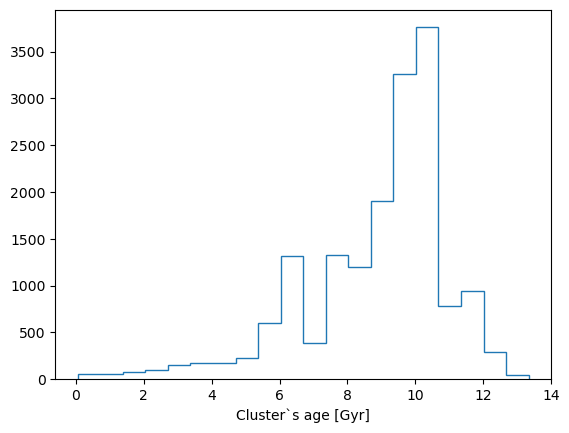

In [61]:
plt.hist(clusters_age, bins=20, histtype='step')
plt.xlabel('Cluster`s age [Gyr]')

Define the age masks

In [62]:
young_mask = (clusters_age<0.5)
old_mask = (clusters_age>6)
veryold_mask = (clusters_age>10)

Compare mass functions

/tmp/ipykernel_473225/2199862883.py:5: RuntimeWarning: divide by zero encountered in log10
  N, _ = np.histogram(np.log10(cluster_masses), bins=np.log10(marray_gcmf))
/tmp/ipykernel_473225/2199862883.py:7: RuntimeWarning: divide by zero encountered in log10
  N, _ = np.histogram(np.log10(cluster_masses[old_mask]), bins=np.log10(marray_gcmf))
/tmp/ipykernel_473225/2199862883.py:9: RuntimeWarning: divide by zero encountered in log10
  N, _ = np.histogram(np.log10(cluster_masses[veryold_mask]), bins=np.log10(marray_gcmf))


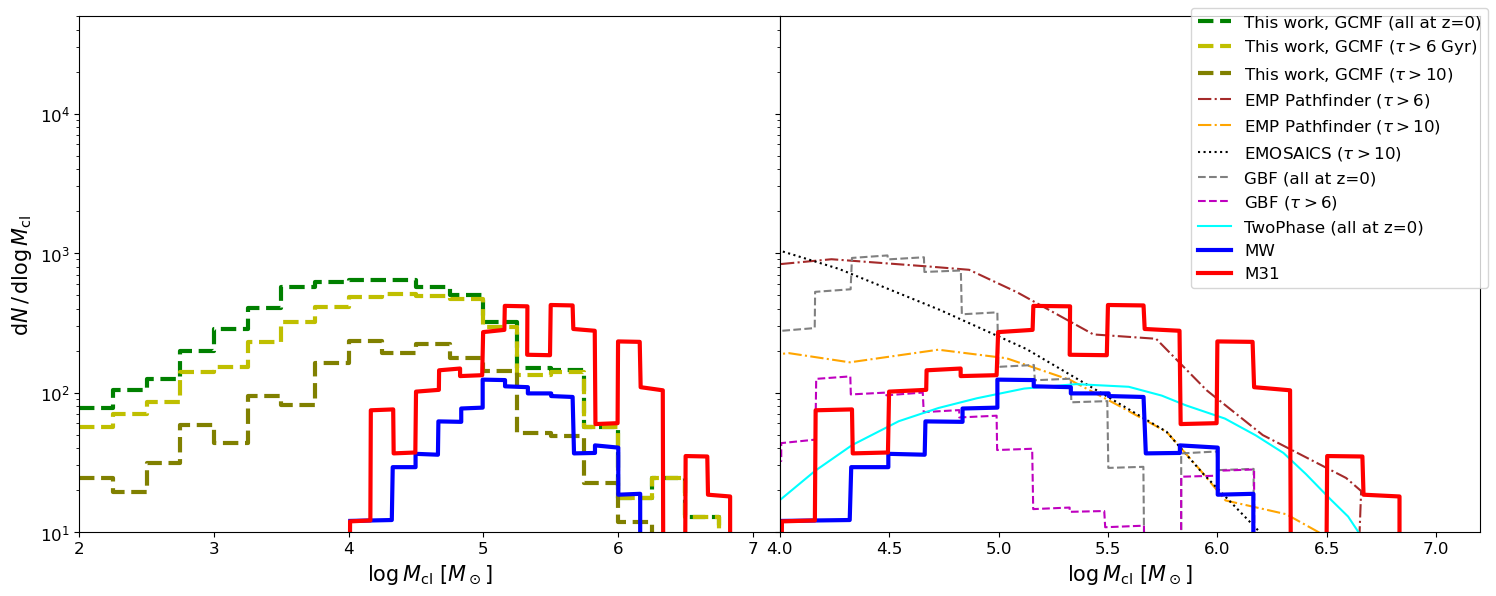

In [64]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15,6))

# N, _ = np.histogram(np.log10(init_cluster_masses), bins=np.log10(marray_icmf))
# ax[0].step(np.log10(marray_icmf[:-1]), N*np.log10(marray_icmf[1:] - marray_icmf[:-1]), where='post', linestyle='dotted', c='purple', label='This work, ICMF')
N, _ = np.histogram(np.log10(cluster_masses), bins=np.log10(marray_gcmf))
ax[0].step(np.log10(marray_gcmf[:-1]), N*np.log10(marray_gcmf[1:] - marray_gcmf[:-1]), where='post', c='g', linestyle='dashed', linewidth = 3, label='This work, GCMF (all at z=0)')
N, _ = np.histogram(np.log10(cluster_masses[old_mask]), bins=np.log10(marray_gcmf))
ax[0].step(np.log10(marray_gcmf[:-1]), N*np.log10(marray_gcmf[1:] - marray_gcmf[:-1]), where='post', c='y', linestyle='dashed', linewidth = 3, label=r'This work, GCMF ($\tau > 6$ Gyr)')
N, _ = np.histogram(np.log10(cluster_masses[veryold_mask]), bins=np.log10(marray_gcmf))
ax[0].step(np.log10(marray_gcmf[:-1]), N*np.log10(marray_gcmf[1:] - marray_gcmf[:-1]), where='post', c='olive', linestyle='dashed', linewidth = 3, label=r'This work, GCMF ($\tau > 10$)')
ax[0].plot(MW_gcmf_dn[:,0], MW_gcmf_dn[:,1], linewidth=3, c='b')
ax[0].plot(M31_gcmf_dn[:,0], M31_gcmf_dn[:,1], linewidth=3, c='r')
ax[0].set_xlim(2,7.2)
ax[0].set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=15)
ax[0].set(ylim=(1e1,5e4), yscale= 'log')
ax[0].set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=15)
ax[0].tick_params(labelsize=12)

ax[1].plot(np.log10(emp_6gyr[:,0]), emp_6gyr[:,1], linestyle='dashdot', c='brown', label=r'EMP Pathfinder ($\tau>6$)')
ax[1].plot(np.log10(emp_10gyr[:,0]), emp_10gyr[:,1], linestyle='dashdot', c='orange', label=r'EMP Pathfinder ($\tau>10$)')
# N, _ = np.histogram(np.log10(init_cluster_masses), bins=np.log10(marray_icmf))
# ax[1].step(np.log10(marray_icmf[:-1]), N*np.log10(marray_icmf[1:] - marray_icmf[:-1]), where='post', linestyle='dotted', c='purple')
ax[1].plot(np.log10(emosaics_gcmf[:,0]), emosaics_gcmf[:,1], c='k', linestyle='dotted', label=r'EMOSAICS ($\tau>10$)')
ax[1].plot(np.log10(gbf_allgcmf[:,0]), np.log10(gbf_allgcmf[:,0])*gbf_allgcmf[:,1], c='gray', linestyle='dashed' ,label='GBF (all at z=0)')
ax[1].plot(np.log10(gbf_oldgcmf[:,0]), np.log10(gbf_oldgcmf[:,0])*gbf_oldgcmf[:,1], c='m', linestyle='dashed' ,label=r'GBF ($\tau>6$)')
ax[1].plot(twophase_gcmf[:,0], twophase_gcmf[:,1], c='cyan' ,label='TwoPhase (all at z=0)')
ax[1].plot(MW_gcmf_dn[:,0], MW_gcmf_dn[:,1], linewidth=3, c='b', label='MW')
ax[1].plot(M31_gcmf_dn[:,0], M31_gcmf_dn[:,1], linewidth=3, c='r', label='M31')
ax[1].set_xlim(4,7.2)
ax[1].set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=15)
ax[1].tick_params(labelsize=12)

fig.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.subplots_adjust(wspace=0)
# plt.savefig('mass_dist_comparison.png')

This is at first dependent on the truncation mass of the ICMF, so let's take a look at its distribution

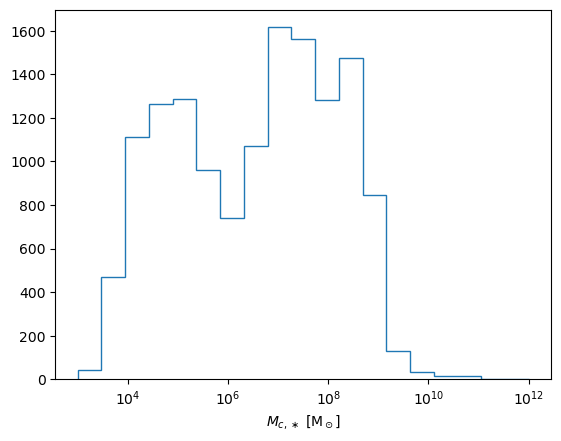

In [65]:
bins = np.logspace(3,12,20)
plt.hist(truncation_mass, bins=bins, histtype='step')
plt.xlabel(r'$M_{c,\ast}$ [M$_\odot$]')
plt.xscale('log')

## Lifetime and mass loss from dynamic evolution

First define a function to perform a scatter plot colored by density

In [66]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density=False)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    h = ax.scatter( x, y, c=z, norm='log', cmap=cm.viridis, **kwargs )

    return ax, h

Let's define the fraction of disrupted clusters by mass bin and also the fraction of surviving mass in clusters

In [67]:
fraction = []
for i in range(24):
  mask = (init_cluster_masses > marray_icmf[i]) & (init_cluster_masses < marray_icmf[i+1])
  mask_disrupted = (clusters_disruptiontime[mask]>0)
  fraction.append(mask_disrupted.sum()/mask.sum())

fraction = np.array(fraction)
fraction = np.nan_to_num(fraction, nan=0.)

In [68]:
massfraction = []
for i in range(24):
  mask = (init_cluster_masses > marray_icmf[i]) & (init_cluster_masses < marray_icmf[i+1])
  massfraction.append(cluster_masses[mask].sum()/init_cluster_masses[mask].sum())

massfraction = np.array(massfraction)
massfraction = np.nan_to_num(massfraction, nan=0.)

And the mass lost by each dynamic mechanism

In [69]:
mevminit = masslostrelax/init_cluster_masses
mshminit = masslostshock/init_cluster_masses

Text(0, 0.5, 'Number')

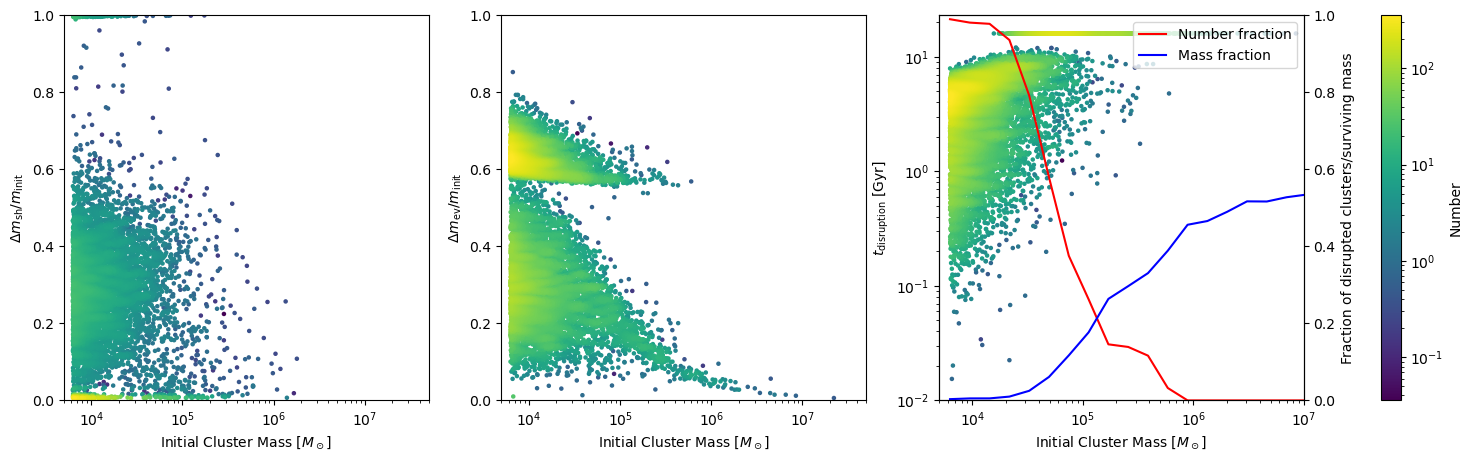

In [70]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0], cb = density_scatter(init_cluster_masses[old_mask], mshminit[old_mask], ax=ax[0],bins=[marray_icmf, np.linspace(0,1.1,100)], edgecolors='face', s=5)
ax[0].set(xscale='log', xlim=(5e3, 5e7), ylim=(0,1), xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$\Delta m_{\rm{sh}}/m_{\rm{init}}$')

ax[1], cb = density_scatter(init_cluster_masses[old_mask], mevminit[old_mask], ax=ax[1],bins=[marray_icmf, np.linspace(0,1.1,100)], edgecolors='face', s=5)
ax[1].set(xscale='log', xlim=(5e3, 5e7), ylim=(0,1), xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$\Delta m_{\rm{ev}}/m_{\rm{init}}$')

ax[2], cb = density_scatter(init_cluster_masses[old_mask], lifetime_gyr[old_mask], ax=ax[2], bins=[marray_icmf, np.logspace(-2,1.5,100)], edgecolors='face', s=5)
ax[2].set(xscale='log', yscale='log', xlim=(5e3, 1e7), ylim=(1e-2, 2.3e1))
ax[2].set(xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$t_{\rm{disruption}}$ [$\rm{Gyr}$]')
ax2 = ax[2].twinx()
ax2.plot((marray_icmf[:-1] + marray_icmf[1:])/2, fraction, color='r', label='Number fraction')
ax2.plot((marray_icmf[:-1] + marray_icmf[1:])/2, massfraction, color='b', label='Mass fraction')
ax2.set_ylim(0, 1)
ax2.set_ylabel('Fraction of disrupted clusters/surviving mass')
ax2.legend()
cbar = fig.colorbar(cb, ax=ax)
cbar.ax.set_ylabel('Number')

# plt.savefig('lostmass_old.pdf')

Are we comparing apples to apples? Not sure, I guess that Marta's plots are with respect to their fiducial model that implementes a minimimum truncation mass in the ICMF too. This changes the ammount of low mass clusters.